In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [4]:
class Config:

    def __init__(self):
        
        # 初始化数据集参数
        self.data_path = 'data/days/all_day_data.csv'
        self.drop_column = ['Date']
        self.label = 'Close'
        self.seq_len = 4
        # self.mode = {'train':'train', 'val':'val', 'test':'test'}
        self.train_split = 0.8
        self.test_split = 0.1      
        self.val_split = 1 - self.train_split - self.test_split
        # 此处应写 train + val + test > 1的异常
        
        # 初始化模型参数
        self.data_last_dim_len = self.load_data_last_dim_len()
        # self.n_vocab = self.load_data_last_dim_len()
        # self.embed_size = [6]
        self.input_size = [6, 128]
        self.lstm_hidden_size = [128, 128]
        self.lstm_num_layers = [1, 1]
        self.lstm_dropout = 0.2
        self.is_bidirectional = False
        self.layer_dropout = 0.5
        self.dense_size = [32]
        self.output_size = 1

        # 初始化训练参数
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 32
        self.is_shuffle = True

        self.learn_rate = 0.001
        self.train_epochs = 100
        

    def load_data_last_dim_len(self):

        table = pd.read_csv(self.data_path)

        for drop_col in self.drop_column:

            table = table.drop(drop_col, axis=1)

        tb = np.array(table)
        
        # print(tb.shape[tb.ndim - 1])
        return tb.shape[tb.ndim - 1]

In [5]:
class PriceData(Dataset):

    def __init__(self, cfg, mode):

        super(PriceData, self).__init__()

        self.data_path = cfg.data_path  
        self.ori_sample_num = 0

        self.feature_mean = []
        self.feature_var = []                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

        self.datas, self.labels = self.load_data(cfg)

        self.train_split, self.val_split, self.test_split = 0, 0, 0
        
        print('feature_mean.len:', len(self.feature_mean), len(self.feature_var))

        # print(self.datas.size(), len(self.labels))

        if mode == 'train':

            self.datas = self.datas[:int(len(self.datas) * cfg.train_split)]
            self.labels = self.labels[:int(len(self.labels) * cfg.train_split)]

        elif mode == 'validation':

            self.datas = self.datas[int(len(self.datas) * cfg.train_split) 
                : int(len(self.datas) * (cfg.train_split + cfg.test_split))]
            self.labels = self.labels[int(len(self.labels) * cfg.train_split) 
                : int(len(self.labels) * (cfg.train_split + cfg.test_split))]
            
        elif mode == 'test':

            self.datas = self.datas[int(
                len(self.datas) * (cfg.train_split + cfg.val_split)):]
            self.labels = self.labels[int(
                len(self.labels) * (cfg.train_split + cfg.val_split)):]

            self.test_mean = self.feature_mean[
                int(len(self.feature_mean) * (cfg.train_split + cfg.val_split)):]
            self.test_var = self.feature_var[
                int(len(self.feature_var) * (cfg.train_split + cfg.val_split)):]
            
            print('test_feature.len:', len(self.test_mean), len(self.test_var))

        print('!!!', mode, 'dataset_info:', len(self.datas), self.datas.shape,
              'label_info:', len(self.labels), self.labels.shape)


    def __getitem__(self, index):

        data, label = self.datas[index], self.labels[index]

        return data, label
    

    def __len__(self):

        return len(self.datas)
    

    def load_data(self, cfg):

        table = pd.read_csv(cfg.data_path)

        for drop_col in cfg.drop_column:

            table = table.drop(drop_col, axis=1)

        label_idx = table.columns.get_loc(cfg.label)
        print('label_idx:', label_idx)

        self.ori_sample_num = len(table)
        print(
            'ori_table.len:', len(table), 
            '\nori_table.columns:', len(table.columns), 'table.col_name:', table.columns,
            '\nori_table.values:', len(table.values),
            '\nori_table.shape:', table.shape
        )

        table = torch.tensor(np.array(table)).float()
        self.feature_mean = table.mean(1)[cfg.seq_len - 1:]
        self.feature_var = table.var(1, unbiased=False)[cfg.seq_len - 1:]
        table = nn.functional.layer_norm(table, (6,))
        print('table.type:', type(table), 'table.shape:', table.shape)

        datas = torch.tensor([])
        labels = torch.tensor([])

        for index in range(len(table) - cfg.seq_len + 1):

            if len(datas) == 0 and len(labels) == 0:

                datas = table[index : index + cfg.seq_len, :].unsqueeze(0)

                labels = table[index + cfg.seq_len - 1, label_idx].view(1)
            
            else:

                datas = torch.cat(
                    [datas, table[index : index + cfg.seq_len, :].unsqueeze(0)], 
                    dim=0
                )

                labels = torch.cat(
                    [labels, table[index + cfg.seq_len - 1, label_idx].view(1)], 
                    dim=0
                )

        print('datas.type:', type(datas[0]), type(labels))

        print('ori_data_set.shape:', datas.shape, 'labels.shape:', labels.shape, labels)

        return datas, labels


In [6]:
cfg = Config()
# db = PriceData(cfg, 'train')
# db = PriceData(cfg, 'validation')
db = PriceData(cfg, 'test')

print('+++++++++++++++++')
for x, y in db:
    print(x, y)
    break
del db

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
test_feature.len: 895 895
!!! test dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
+++++++++++++++++
tensor([[-0.2894, -0.2783, -0.2752, -0.2994,  2.1556, -1.0133],
        [-0.2752, -0.2813, -0.2674, -0.2881,  2.1485, -1.0365],
        [-0.0938, -0.0926, -0.0743, -0.1070,  1.9011, -1.5334],
        [ 0.0564,  0.0997,  0.1013,  0.0372,  1.5749, -1.8695]]) tensor(0.0564)


In [7]:
def data_loader(data, cfg):

    return DataLoader(
        data,
        batch_size=cfg.batch_size,
        shuffle=cfg.is_shuffle,
        # num_workers= 4
    )

In [8]:
import torch.nn as nn
from torch import optim
from torcheval.metrics.functional import r2_score

In [9]:
class Predict(nn.Module):

    def __init__(self, cfg):

        super(Predict, self).__init__()

        self.layer_norm = nn.LayerNorm(cfg.data_last_dim_len)

        # self.embedding = nn.Embedding(cfg.n_vocab, cfg.embed_size)

        self.lstm1 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[0],
            cfg.lstm_hidden_size[0],
            cfg.lstm_num_layers[0],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.lstm2 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[1],
            cfg.lstm_hidden_size[1],
            cfg.lstm_num_layers[1],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.dropout = nn.Dropout(cfg.layer_dropout)
        
        self.dense1 = nn.Linear(cfg.lstm_hidden_size[1], cfg.dense_size[0])
        self.dense2 = nn.Linear(cfg.dense_size[0], cfg.output_size)

        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        # print('input_dataset.type:', x.type())
        # norm = self.layer_norm(x)
        # print('norm.type:', norm.size())
        lstm1, _ = self.lstm1(x)
        # print('lstm1.type:', lstm1.size())
        dropout1 = self.dropout(lstm1)
        # print('dropout1.type:', dropout1.size())
        lstm2, _ = self.lstm2(dropout1)
        # print('lstm2.type:', lstm2.size())
        lstm_last = lstm2[:, -1, :]
        # print('lstm_last.type:', lstm_last.size())
        dropout2 = self.dropout(lstm_last)
        # print('dropout2.type:', dropout2.size())
        fc1 = self.dense1(dropout2)
        # print('fc1.type:', fc1.size())
        # fc1 = self.dropout1(fc1)
        rl_out = self.relu(fc1)
        # print('rl_out.type:', rl_out.size())
        out = self.dense2(rl_out).squeeze()
        # print('out.type:', out.size())

        # out = self.layer_norm(x)
        # out, _ = self.lstm1(out)
        # out = self.dropout1(out)
        # out, _ = self.lstm2(out)
        # out = self.dropout2(out)
        # out = self.dense1(out)
        # out = self.relu(out)
        # out = self.dense2(out)

        return out
        


In [10]:
cfg = Config()
# print(cfg.device)
model = Predict(cfg)
model.to(cfg.device)
print(model)

Predict(
  (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)


In [11]:
def model_structure(model):
    blank = ' '
    print('-' * 90)
    print('|' + ' ' * 11 + 'weight name' + ' ' * 10 + '|' \
          + ' ' * 15 + 'weight shape' + ' ' * 15 + '|' \
          + ' ' * 3 + 'number' + ' ' * 3 + '|')
    print('-' * 90)
    num_para = 0
    type_size = 1  # 如果是浮点数就是4

    for index, (key, w_variable) in enumerate(model.named_parameters()):
        if len(key) <= 30:
            key = key + (30 - len(key)) * blank
        shape = str(w_variable.shape)
        if len(shape) <= 40:
            shape = shape + (40 - len(shape)) * blank
        each_para = 1
        for k in w_variable.shape:
            each_para *= k
        num_para += each_para
        str_num = str(each_para)
        if len(str_num) <= 10:
            str_num = str_num + (10 - len(str_num)) * blank

        print('| {} | {} | {} |'.format(key, shape, str_num))
    print('-' * 90)
    print('The total number of parameters: ' + str(num_para))
    print('The parameters of Model {}: {:4f}M'.format(model._get_name(), num_para * type_size / 1000 / 1000))
    print('-' * 90)

model_structure(model)

------------------------------------------------------------------------------------------
|           weight name          |               weight shape               |   number   |
------------------------------------------------------------------------------------------
| layer_norm.weight              | torch.Size([6])                          | 6          |
| layer_norm.bias                | torch.Size([6])                          | 6          |
| lstm1.weight_ih_l0             | torch.Size([512, 6])                     | 3072       |
| lstm1.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |
| lstm1.bias_ih_l0               | torch.Size([512])                        | 512        |
| lstm1.bias_hh_l0               | torch.Size([512])                        | 512        |
| lstm2.weight_ih_l0             | torch.Size([512, 128])                   | 65536      |
| lstm2.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |

In [12]:
train_db = PriceData(cfg, 'train')
    # db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'test')

train_loader = data_loader(train_db, cfg)

print('++++++++++++++++++++++++++++')
print('train.type', type(train_loader), len(train_loader))
for x, y in train_loader:
    print(x)
    print(y)
    break

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
!!! train dataset_info: 7159 torch.Size([7159, 4, 6]) label_info: 7159 torch.Size([7159])
++++++++++++++++++++++++++++
train.type <class 'torch.utils.data.dataloader.DataLoader'> 224
tensor([[[ 5.0918e-01,  4.3883e-01,  5.2253e-01,  4.3437e-01,  3.2662e-01,
          -2.2315e+00],
         [ 5.5655e-01,  5.6545e-01,  6.0818e-01,  5.4586e-01, -1.1029e-01,
          -2.1658e+00],
         [ 7.0504e-01,  6.6933e-01,  7.1694e-01,  6.6695e-01, -9.9696e-01,
          -1.7613e+00],
         [ 4.

In [13]:
val_db = PriceData(cfg, 'validation')

val_loader = data_loader(val_db, cfg)
print('++')
print('val.type', type(val_loader), len(val_loader))

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
!!! validation dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
++
val.type <class 'torch.utils.data.dataloader.DataLoader'> 28


In [14]:
test_db = PriceData(cfg, 'test')
cfg.is_shuffle = False
test_loader = data_loader(test_db, cfg)
print('++')
print('test.type', type(test_loader), len(test_loader))

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
test_feature.len: 895 895
!!! test dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
++
test.type <class 'torch.utils.data.dataloader.DataLoader'> 28


In [15]:
optimizer = optim.Adam(model.parameters(), lr=cfg.learn_rate)
criteon = nn.MSELoss().to(cfg.device)

In [17]:
import visdom

viz = visdom.Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss', legend=['loss']))
viz.line([0.], [0.], win='train_epoch_loss', opts=dict(title='train epoch loss', legend=['loss']))
viz.line([0.], [0.], win='validation_acc', opts=dict(title='validation acc', legend=['acc']))
# viz.line([0.], [-1.], win='train_loss_epoch', opts=dict(title='train loss&acc', legend=['loss', 'acc']))

# viz.line([loss.item()], [global_step], win='train_loss', update='append')

Setting up a new session...


'validation_acc'

In [18]:
# from ignite.contrib.metrics.regression import r2_score

In [19]:
def evaluate(model, loader, mode='train'):

    r2 = 0
    total = len(loader)
    pred = []
    # print(len(loader))
    for x, y in loader:

        x, y = x.to(cfg.device), y.to(cfg.device)
        # print(x.shape, y.shape)
        # print('y', y)
        with torch.no_grad():
            logits = model(x)
        # print('logits', logits)
        # print('y', y)
        # print(r2)
        r2 += r2_score(logits, y).sum().float().item()

        # metric = R2Score(device=cfg.device)
        # metric.update(logits, y)
        # r2 = metric.compute()
        # print(len(logits))

        if mode == 'untrain':
            
            for i in range(len(logits)):

                pred.append(logits[i].item())

    if mode == 'untrain':
        # print('total:', total)
        return r2 / total, pred

    return r2 / total

In [20]:
model.eval()
model.load_state_dict(torch.load('best.mdl'))

test_r2, pred = evaluate(model, test_loader, mode='untrain')

print(test_r2)
print(pred)

0.9944769101483482
[0.07017882168292999, 0.6778740882873535, -0.35362040996551514, -0.33698105812072754, -0.3461812138557434, -0.34244170784950256, -0.3114917278289795, -0.3204391300678253, -0.31599101424217224, -0.325901597738266, -0.33157190680503845, -0.30128389596939087, -0.01124187558889389, -0.2957083284854889, -0.2971518933773041, -0.2997019588947296, -0.28257352113723755, -0.28969788551330566, -0.27207568287849426, -0.22649934887886047, -0.056413449347019196, 0.6626712083816528, -0.35026389360427856, -0.3458189368247986, -0.3453068733215332, -0.34761935472488403, -0.3831929862499237, -0.39644119143486023, -0.38634535670280457, -0.38352516293525696, -0.3875340521335602, -0.37578973174095154, -0.3636157214641571, -0.3517315983772278, -0.37513408064842224, -0.37283775210380554, -0.374026894569397, -0.3687622547149658, -0.3524748980998993, -0.33231785893440247, -0.32348793745040894, -0.30323526263237, -0.1696460247039795, 0.6098620891571045, -0.3741762936115265, -0.3850909769535064

In [18]:
pred = torch.from_numpy(np.array(pred))
print(type(pred), pred.shape)
print(type(test_db.test_mean), test_db.test_mean.shape)
print(type(test_db.test_var), test_db.test_var.shape)

<class 'torch.Tensor'> torch.Size([895])
<class 'torch.Tensor'> torch.Size([895])
<class 'torch.Tensor'> torch.Size([895])


In [19]:
def denormalize(value, mean, var):

    new_value = value * var.sqrt() + mean

    return new_value

denormalized_value = denormalize(pred, test_db.test_mean, test_db.test_var).numpy()
print(denormalized_value.size, denormalized_value.shape)
print(denormalized_value)

895 (895,)
[ 58.47986077  58.2886538   59.83849579  55.56795676  56.8166671
  56.31210809  54.17275731  53.5155559   53.61231235  55.53109583
  56.38354328  56.01357261  57.78758954  56.57505052  57.61584217
  58.46468234  57.92819935  55.54324767  54.98213738  53.98309622
  52.35871171  50.39146156  54.83448703  53.75566563  52.79629727
  51.70374331  50.13464117  38.25644854  39.63207733  39.20887705
  36.32069236  35.47516355  34.79514944  29.93077012  28.11561586
  29.38056219  29.45594891  27.70374092  28.00921758  27.31958153
  26.5710314   24.91089088  22.93259436  22.82751824  29.14353692
  31.92727714  36.17016706  33.98270279  33.91897959  34.05414376
  35.20503675  32.64671496  31.8590371   29.43927119  29.09010595
  29.53435635  28.11604061  23.99835161  21.45435033  22.7775709
  22.29623678  20.9248258   20.31095266  22.30576132  24.3892167
  28.99088423  27.69215101  31.59628349  31.5214165   30.82376711
  30.14261774  31.24475397  30.31139404  30.19455037  31.20403663
  

In [20]:
print(len(test_db.datas), len(test_db.labels))

895 895


In [21]:
table = pd.read_csv(cfg.data_path)
print(table['Close'][-len(test_db.datas):])

8057    58.29
8058    58.16
8059    54.45
8060    53.96
8061    55.28
        ...  
8947    80.11
8948    81.36
8949    79.87
8950    78.50
8951    79.63
Name: Close, Length: 895, dtype: float64


In [22]:
true_data = np.array(table['Close'][-len(test_db.datas):])
error = denormalized_value - true_data
print(error)

[ 1.89860768e-01  1.28653796e-01  5.38849579e+00  1.60795676e+00
  1.53666710e+00  1.38210809e+00 -2.97242692e-01  2.45555902e-01
 -3.97687654e-01 -2.58904173e-01  4.35432753e-02 -1.30642739e+00
  1.17589543e-01 -1.17494948e+00 -1.50415783e+00 -8.45317655e-01
 -5.71800648e-01 -7.56752334e-01  3.21373824e-02  5.53096224e-01
  1.78711710e-01 -1.28538442e-01  2.93448703e+00  1.89566563e+00
  1.66629727e+00  1.71374331e+00  4.86464117e+00  3.89644854e+00
  2.41207733e+00  3.41887705e+00  3.10069236e+00  1.62516355e+00
  4.74514944e+00  1.20077012e+00  3.23561586e+00  9.10562191e-01
  2.47594891e+00  6.73740923e-01  8.59217575e-01 -7.04184705e-02
  2.31031403e-01 -1.91091173e-02  1.72594358e-01  8.75182433e-02
  4.40353692e+00  1.98727714e+00  2.06016706e+00  9.32702787e-01
  2.04897959e+00  1.21414376e+00  3.72503675e+00  9.06714955e-01
  2.25903710e+00  1.74927119e+00  1.27010595e+00  1.45435635e+00
  2.54604061e+00  4.66835161e+00  1.08435033e+00  1.44757090e+00
  8.56236778e-01  9.34825

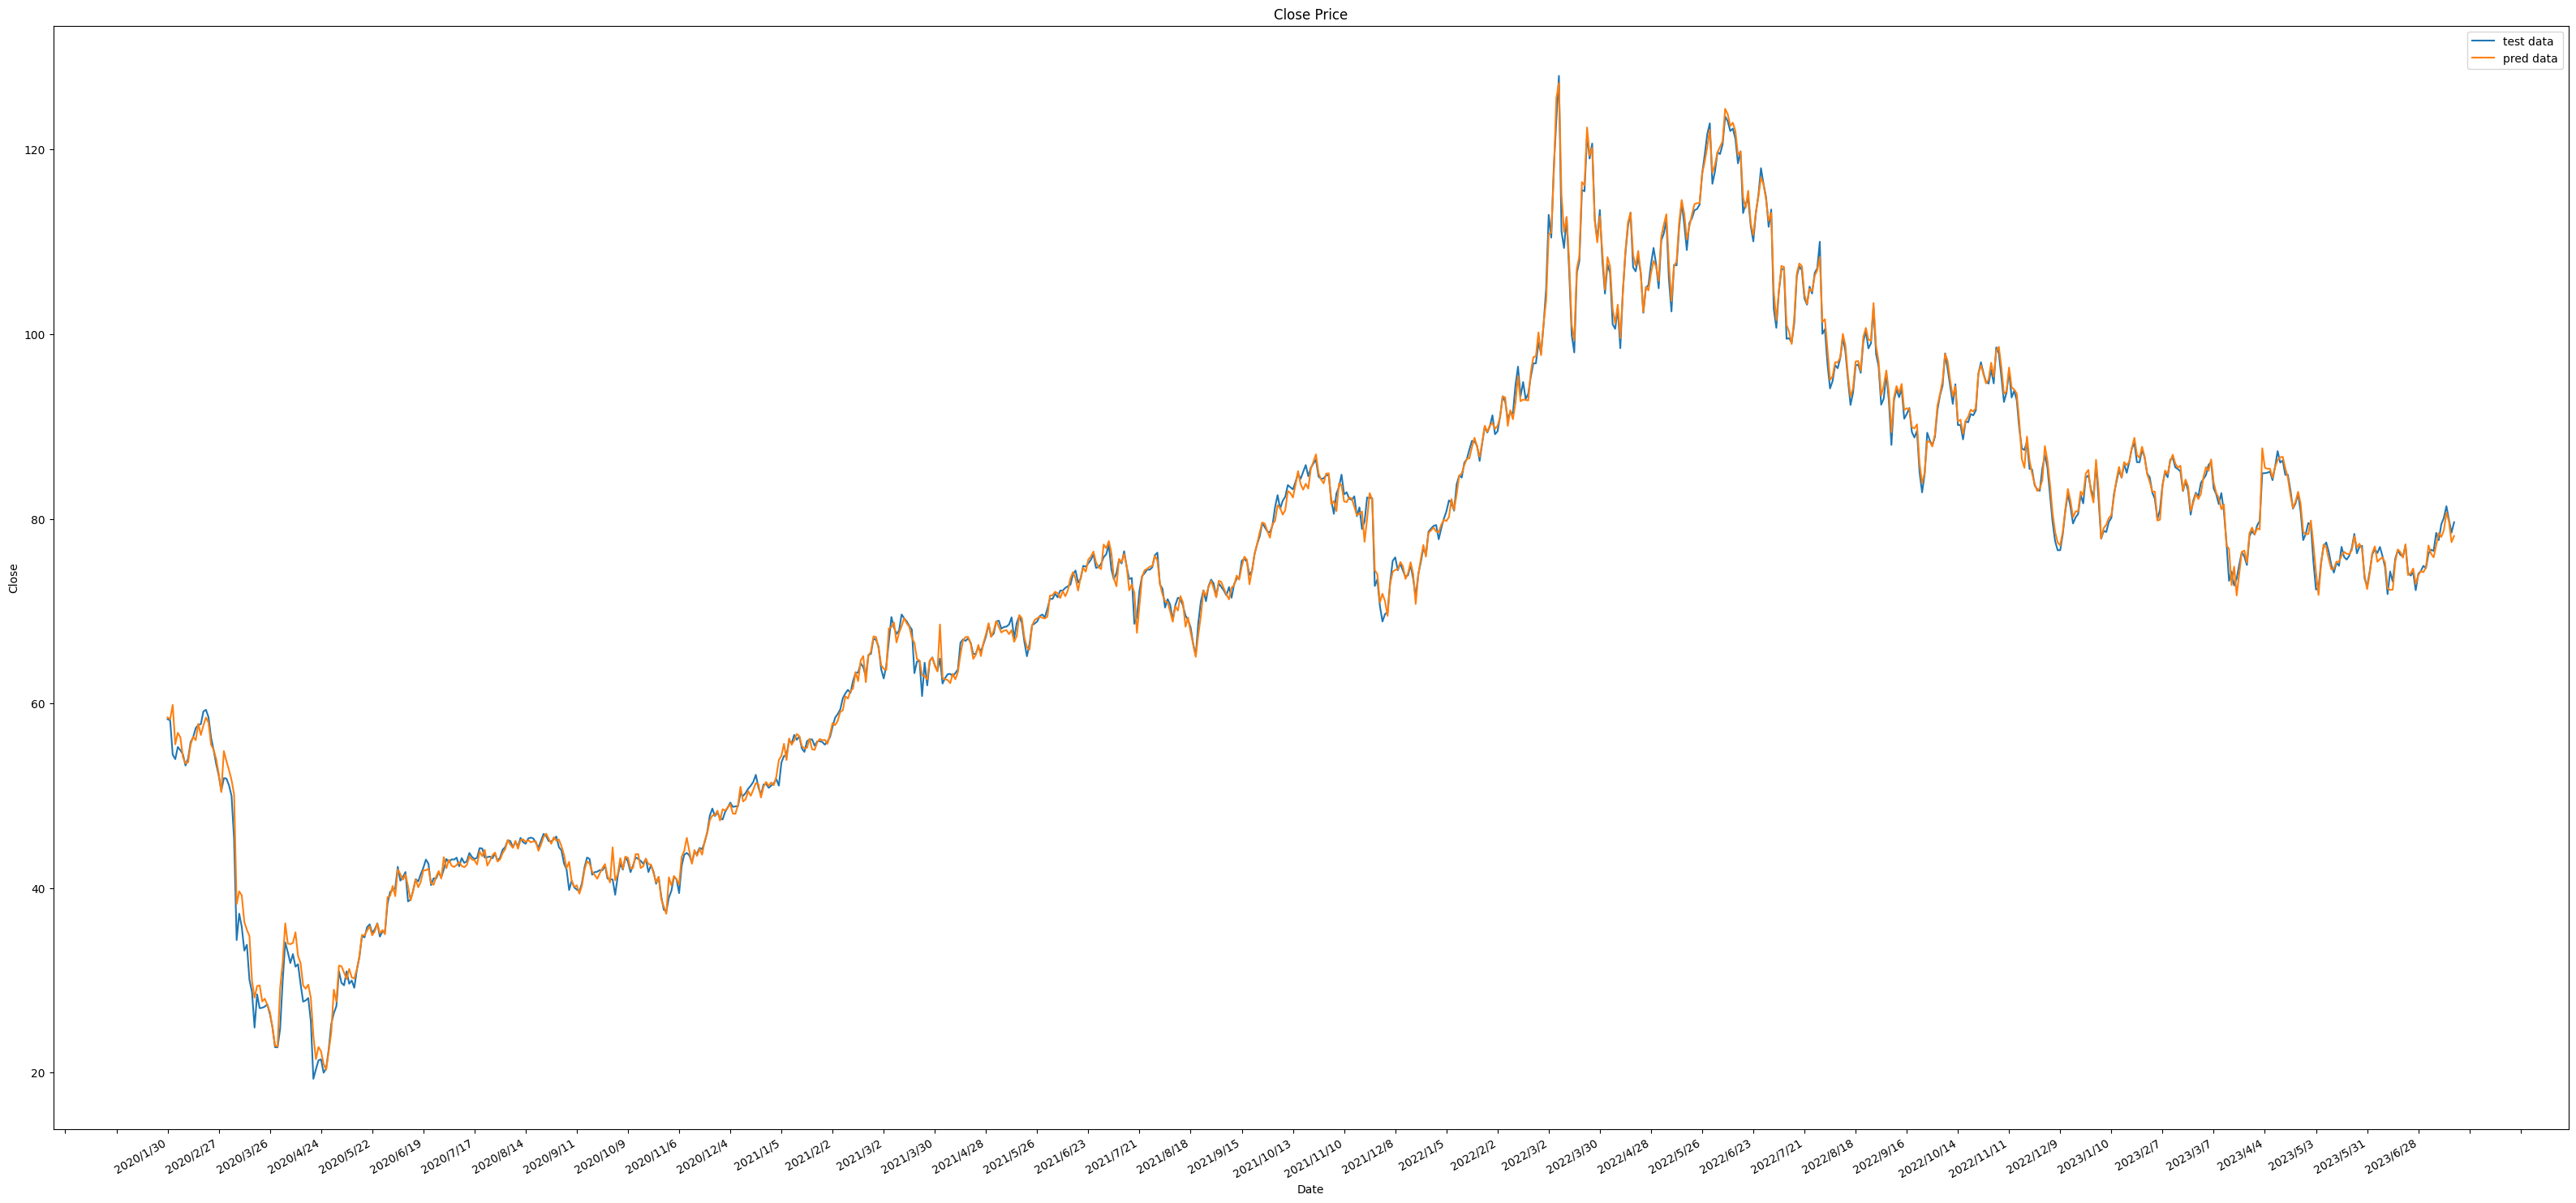

In [23]:
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(figsize=(40,20))

# xdata = db['Date']

ax0.plot(table["Date"][-len(test_db.datas):], table["Close"][-len(test_db.datas):], label="test data")
ax0.plot(table["Date"][-len(test_db.datas):], denormalized_value, label="pred data")

ax0.xaxis.set_major_locator(plt.MultipleLocator(20))
fig.autofmt_xdate() #自动旋转xlabel

ax0.set_title("Close Price")
ax0.set_xlabel("Date")
ax0.set_ylabel("Close")

ax0.legend()

plt.show()

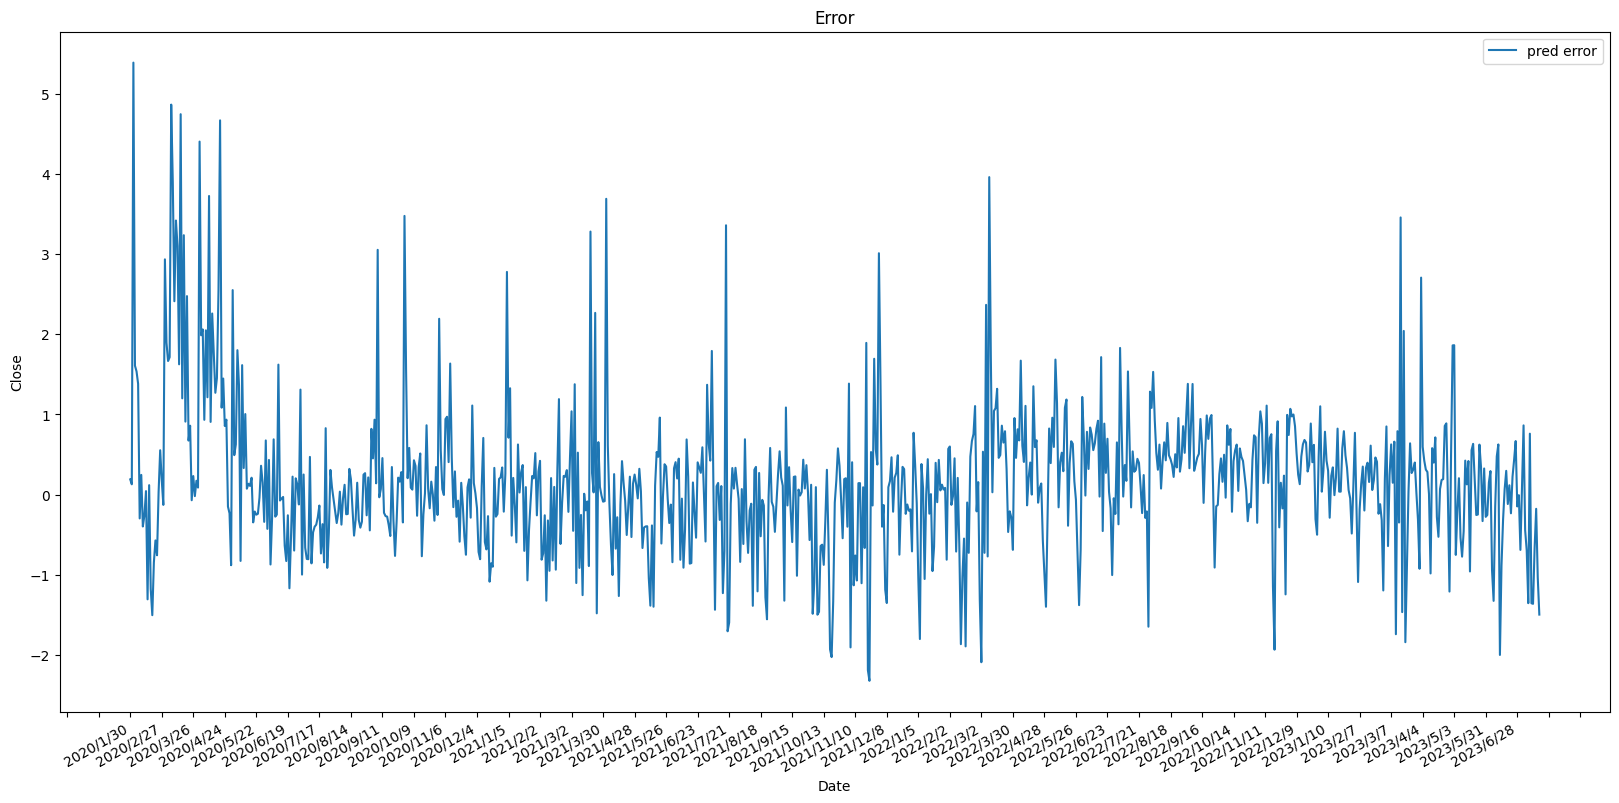

In [24]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20,10))

# xdata = db['Date']

# ax0.plot(table["Date"][-len(test_db.datas):], table["Close"][-len(test_db.datas):], label="test data")
ax1.plot(table["Date"][-len(test_db.datas):], error, label="pred error")

ax1.xaxis.set_major_locator(plt.MultipleLocator(20))
fig.autofmt_xdate() #自动旋转xlabel

ax1.set_title("Error")
ax1.set_xlabel("Date")
ax1.set_ylabel("Close")

ax1.legend()

plt.show()

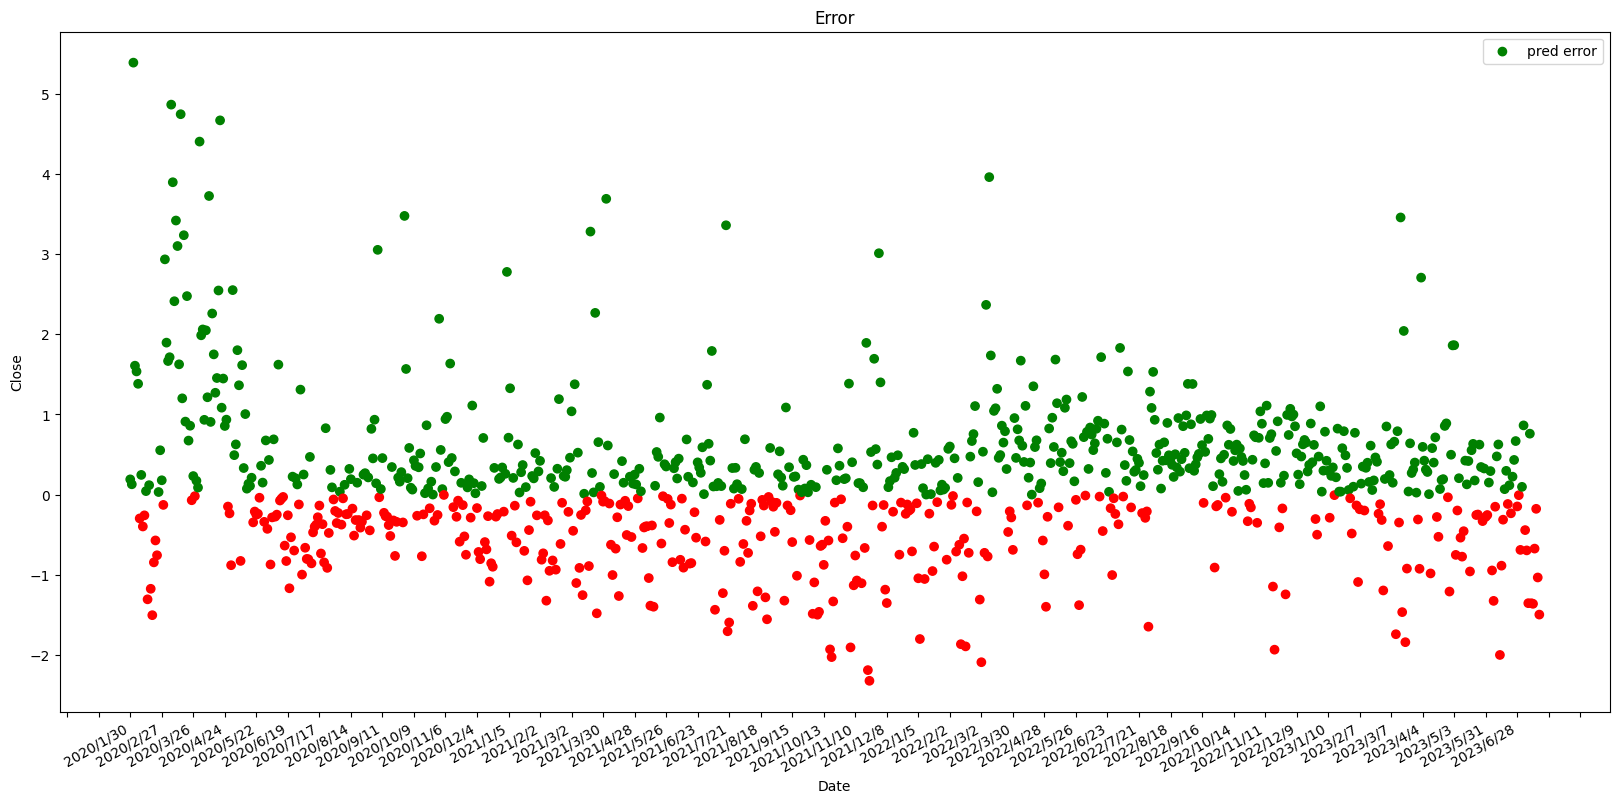

In [25]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20,10))

# xdata = db['Date']

# ax0.plot(table["Date"][-len(test_db.datas):], table["Close"][-len(test_db.datas):], label="test data")
ax1.scatter(table["Date"][-len(test_db.datas):], error, label="pred error", c=np.where(error>0,'g','r'))

ax1.xaxis.set_major_locator(plt.MultipleLocator(20))
fig.autofmt_xdate() #自动旋转xlabel

ax1.set_title("Error")
ax1.set_xlabel("Date")
ax1.set_ylabel("Close")

ax1.legend()

plt.show()

In [26]:
from sklearn.metrics import r2_score
# R_2 = r2_score(y_test,prediction)
# print(R_2)

In [27]:
from torchsummary import summary

# summary(model, (1823, 4, 6))
summary(model,(4, 6))
# del model0

AttributeError: 'tuple' object has no attribute 'size'

[WinError 10054] 远程主机强迫关闭了一个现有的连接。
Visdom.setup_socket.<locals>.on_close() takes 1 positional argument but 3 were given
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
Visdom.setup_socket.<locals>.on_close() takes 1 positional argument but 3 were given


In [ ]:
import torch
import torchvision
# 导入torchsummary
from torchsummary import summary

# 需要使用device来指定网络在GPU还是CPU运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 建立神经网络模型，这里直接导入已有模型
# model = model().to(device)
model = torchvision.models.vgg11_bn().to(device)
# 使用summary，注意输入维度的顺序
summary(model, input_size=(3, 224, 224))